# Importing Packages

In [37]:
import numpy as np
import pandas as pd
import json
import math
import nltk
import re
import string
import requests
from nltk import word_tokenize
from wordcloud import STOPWORDS
import emoji
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import imageio
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from collections import OrderedDict

# Tool Functions

get_arc(a,b)

    return distance between 2 buildings

    a, b : (x,y,z)
        x, y, z coordinates of buildings

In [40]:
def get_arc(a, b):
    R_const = 6378137 # unit m
    angle = math.acos(np.dot(a,b)/(norm_eu(a)*norm_eu(b)))*180/math.pi
    arc = angle * math.pi * R_const / 180
    return arc

norm_eu(x)

    return Euclidean norm of a vector

    x: list
        vector

In [41]:
def norm_eu(x):
    ret = 0
    for i in range(len(x)):
        temp = x[i]
        ret += temp**2
    return math.sqrt(ret)

get_geo_df()

    return full geo data frame

In [42]:
def get_geo_df():
    # building
    df = pd.read_csv('.\\Data\\Building\\rentcity-data-20210203-part-1-of-13.csv')
    for i in range(1, 14):
        file_name = f".\\Data\\Building\\rentcity-data-20210203-part-{i}-of-13.csv"
        df_i = pd.read_csv(file_name)
        df = df.append(df_i)
    df = df.reset_index().drop(columns=['index'])
    
    # geojson
    geojs = pd.read_json('.\\Data\\new-building-export.json')
    
    # full data
    df_full = pd.merge(df, geojs, right_on='google_place_id', left_on='Google Places ID', how = 'left')
    df_full['Walk Score'] = df_full['Walk Score'].apply(lambda x: int(x[:-1])/100)
    df_full = df_full.sort_values(['RentCity Score', 'Count of Reviews'], ascending=False).drop_duplicates(['Google Places ID']).reset_index().drop(columns=['index'])
    df_full['lat_arc'] = df_full['latitude'].apply(lambda x: x*math.pi/180)
    df_full['lon_arc'] = df_full['longitude'].apply(lambda x: x*math.pi/180)
    df_full['x'] = df_full.apply(lambda x: math.cos(x['lat_arc'])*math.cos(x['lon_arc']), axis = 1)
    df_full['y'] = df_full.apply(lambda x: math.cos(x['lat_arc'])*math.sin(x['lon_arc']), axis = 1)
    df_full['z'] = df_full.apply(lambda x: math.sin(x['lat_arc']), axis = 1)
    
    return df_full

remove_top_freq(s, freq = 0.05)

    remove top frequent words in a string

    s: string
        reviews
    freq: float, optinal
        frequency boundary
    

In [43]:
def remove_top_freq(s, freq = 0.05):
    s_l = s.split()
    ret_s = []
    word_freq = FreqDist(s_l)
    most_freq_word = FreqDist(s_l).most_common(int(len(set(s_l))*freq))
    most_freq_word = dict(most_freq_word)
    for i in range(len(s_l)):
        w = s_l[i]
        if w not in most_freq_word.keys():
            ret_s.append(w)
    return " ".join(ret_s)

get_top_words(s, MAX_count = 5)

    return most frequent words in a string

    s: string
        reviews
    MAX_count: int, optional
        max number of words


In [44]:
def get_top_words(s, MAX_count = 5):
    s_l = s.split()
    ret_s = []
    word_freq = FreqDist(s_l)
    most_freq_word = FreqDist(s_l).most_common(MAX_count)
    most_freq_word = dict(most_freq_word)
#     for i in range(len(s_l)):
#         w = s_l[i]
#         if w in most_freq_word.keys():
#             ret_s.append(w)
    return list(most_freq_word.keys())

get_overlap_words(wc1,wc2)

    return overlapping words in 2 wordclouds

    wc1, wc2: wordcloud
        wordcloud of reviews

In [45]:
def get_overlap_words(wc1,wc2):
    words1 = list(wc1.words_.keys())
    words2 = list(wc2.words_.keys())    
    ret_l = []
    for i in range(len(words1)):
        w = words1[i]
        if w in words2:
            ret_l.append(w)
    return ret_l

removePunc(s)

    remove punctuation in a string

    s: string
        reviews

In [46]:
def removePunc(s):
    import re
    import string
    pattern = re.compile('[\u4e00-\u9fa5]')
    s = re.sub(pattern,"",s)
    s = re.sub('[^A-Za-z.]',' ',s)
    punc = string.punctuation+"‘’“”—…‑"
    pattern = '[{}]'.format(re.escape(punc))
    s = re.sub(pattern, ' ', s)
    s = " ".join(s.split())
    s = s.lower()
    return s

remove_stop_word(s)

    remove stopping words and words with length smaller than 2 in a string

    s: string
        reviews

In [47]:
def remove_stop_word(s):
    words = s.split()
    ret_l = []
    for i in range(len(words)):
        w = words[i]
        if w not in STOPWORDS and len(w) > 2:
            ret_l.append(w)
    return ' '.join(ret_l)

emoji_process(s)

    translate emoji to words

    s: string
        reviews

In [48]:
def emoji_process(s):
    s_demo = emoji.demojize(s)
    ret_s = removePunc(s_demo)
    return ret_s

remove_at(s)

    remove @ in reviews

    s: string
        reviews

In [49]:
def remove_at(s):
    s = str(s)
    s_l = s.split()
    ret_s = ''
    count = 0
    for i in range(len(s_l)):
        temp = s_l[i]
        if temp[0] == '@' and len(temp) != 1:
            count += 1
        else:
            ret_s += ' '+temp
    ret_s = ret_s[1:]
    return {'count': count,
            'return_string': ret_s}

get_hashtag(s)

    get hash tags, counts of hash tags, and string after removing hash tages of reviews

    s: string
        reviews

In [50]:
def get_hashtag(s):
    s = str(s)
    s_l = s.split()
    count = 0
    tag_l = []
    ret_s = ''
    for i in range(len(s_l)):
        temp = s_l[i]
        if temp[0] == '#' and len(temp) != 1:
            count += 1
            tag_l.append(temp[1:])
            ret_s += ' ' + temp[1:]
        else:
            ret_s += ' ' + temp
    ret_s = ret_s[1:]
    for i in range(len(tag_l)):
        tag_l[i] = remove_punc(tag_l[i])
    return {'tag_count': count,
            'tags': tag_l,
            'return_string': ret_s}

remove_hyperlink(s)

    remove hyperlink in a string

    s: string
        reviews

In [51]:
def remove_hyperlink(s):
    s = str(s)
    ret_s = ''
    s_l = s.strip('\n').split()
    for i in range(len(s_l)):
        temp = s_l[i]
        if temp[:4] == 'http':
            continue
        else:
            ret_s += ' ' + temp
    ret_s = ret_s[1:]
    return ret_s

get_words()

    get positive and negative word sentiments from Hu and Lu's webpage

pos_neg_sentiments(s)

    get positive, negative and different between pos and neg sentiments from Hu and Lu's dictionary of a review

    s: string
        review

In [52]:
def get_words():
    p_url = 'http://ptrckprry.com/course/ssd/data/positive-words.txt'
    n_url = 'http://ptrckprry.com/course/ssd/data/negative-words.txt'
    
    pos_word_list = requests.get(p_url).content.decode('latin-1').split('\n')
    idx = 0
    while idx < len(pos_word_list):
        if ";" in pos_word_list[idx] or pos_word_list[idx] == "":
            pos_word_list.pop(idx)
        else:
            idx += 1
            
    neg_word_list = requests.get(n_url).content.decode('latin-1').split('\n')
    idx = 0
    while idx < len(neg_word_list):
        if ";" in neg_word_list[idx] or neg_word_list[idx] == "":
            neg_word_list.pop(idx)
        else:
            idx += 1
            
    return pos_word_list, neg_word_list

pos_word_list, neg_word_list = get_words() # recommend to run globally to save time
def pos_neg_sentiment(s):
#     pos_word_list, neg_word_list = get_words()
    
    pos_count = 0
    neg_count = 0
    words = word_tokenize(s)
    words = remove_stop_word(words)
    for i in range(len(words)):
        w = words[i]
        if w in pos_word_list:
            pos_count += 1
        if w in neg_word_list:
            neg_count += 1
    pos_pct = pos_count/len(words)
    neg_pct = neg_count/len(words)
    pos_neg_diff = pos_pct - neg_pct
    ret_d = {'pos rate': pos_pct,
            'neg rate': neg_pct,
            'pos neg diff': pos_neg_diff}
    return ret_d

nrc_emotion_dict()

    get NRC sentiment dictionary

nrc_sentiment(s)

    get NRC sentiments of a review

    s:string 
        reviews

In [53]:
def nrc_emotion_dict():
    file_dir = ".\\Data\\NRC.txt"
    with open(file_dir, 'r') as f:
        lines = f.readlines()
    emotion_dict = dict()
    start_idx = 46
    for i in range(start_idx, len(lines)):
        line_l = lines[i].strip().split()
        word = line_l[0]
        emotion = line_l[1]
        t_or_f = line_l[2]
        if t_or_f == "1":
            if word in emotion_dict.keys():
                emotion_dict[word].append(emotion)
            else:
                emotion_dict[word] = [emotion]
    return emotion_dict

emotion_dict = nrc_emotion_dict() # recommend to run globally to save time
def nrc_sentiment(s):
    count_dict = {"anger": 0,
                "anticipation": 0,
                "disgust": 0,
                "fear": 0,
                "joy": 0,
                "negative": 0,
                "positive": 0,
                "sadness": 0,
                "surprise": 0,
                "trust": 0}
#     emotion_dict = nrc_emotion_dict()
    words = word_tokenize(s)
#     words = remove_stop_word(words)
    for i in range(len(words)):
        w = words[i]
        if w in emotion_dict.keys():
            e_l = emotion_dict[w]
            for j in range(len(e_l)):
                e = e_l[j]
                count_dict[e] += 1
    for k in count_dict.keys():
        if len(words) > 0:
            count_dict[k] /= len(words)
        else:
            count_dict[k] = 0
    return count_dict

get_word_freq_top(s_l, top = 3)

    get top freqent words from a word list

    s_l: list
        word list of reviews
    top: int, option
        number of most freqent words

In [54]:
def get_word_freq_top(s_l, top = 3):
    s_d = dict()
    for i in range(len(s_l)):
        w = s_l[i]
        if w not in s_d.keys():
            s_d[w] = 1
        else:
            s_d[w] += 1
    sort_l = sorted(s_d.items(), key=lambda x: x[1], reverse=True)
    
    ret_l = []
    if len(sort_l) <= top:
        for i in range(len(sort_l)):
            e = sort_l[i]
            ret_l.append(e[0])
        return ret_l
    elif sort_l[top-1][1] == sort_l[top][1]:
        cut_point = sort_l[2][1]
        for i in range(len(sort_l)):
            e = sort_l[i]
            if cut_point <= e[1]:
                ret_l.append(e[0])
            else:
                break
        return ret_l
    else:
        for i in range(top):
            e = sort_l[i]
            ret_l.append(e[0])
        return ret_l

get_noun_adj(s)

    return review with only noun and adj
    
    s: string
        review

In [86]:
def get_noun_adj(s):
    s_l = s.split()
    ret_l = []
    tag_l = nltk.pos_tag([i for i in s_l if i not in STOPWORDS])
    tag_l = [i for i in tag_l if i[1] == "NN" or i[1] == "JJ"]
    tag_l = pd.DataFrame(tag_l)[0].to_list()
    for i in range(len(s_l)):
        si = s_l[i]
        if si in tag_l:
            ret_l.append(si)
    return " ".join(ret_l)

# Implementations

### NRC Sentiments

NRC sentiments 

In [21]:
nrc_sent_l = ["anger","anticipation","disgust","fear","joy","negative","positive","sadness","surprise","trust"]
nrc_pos_neg_l = ["positive","joy","trust","anticipation","surprise","negative","anger","disgust","fear","sadness"]

get geo data from json

In [22]:
df_geo = get_geo_df()

read review and rating data

In [23]:
df_rating = pd.read_csv('.\Data\Review\Review.csv')
df_rating = df_rating[pd.notna(df_rating['Google Places ID'])]
df_rating = df_rating.drop(columns=['Street Address', 'Neighborhood Mapping', 'City', 'Zipcode',
                                    'RentCity Score', 'Neighborhood Safety Score', 'Walkability Score', 'Building Violations Score'])

merge previous data to full data frame

In [24]:
df_full = pd.merge(df_rating, df_geo, left_on=['Google Places ID'], right_on=['google_place_id'])

get review data from full data

In [25]:
df_review = df_full[['google_place_id',
        'Overall Rating (1-5)',
        'Any advice for future tenants?',
        'RentCity Score',
        'Neighborhood Safety Score',
        'Walk Score',
        'latitude', 'longitude', 'lat_arc',
        'lon_arc', 'x', 'y', 'z']]
df_review.columns = ['google place id', 'rating', 'review', 'rentcity score',
                    'neighbor safety score', 'walk score',
                    'latitude', 'longitude',
                    'lat_arc', 'lon_arc', 'x', 'y', 'z']

**clean review data**

1. translate emoji to words
2. remove stopping words
3. count number of words in each review
4. filter valid reviews with more than 0 words
5. get NRC sentiment score for each review

In [29]:
df_review['review'] = df_review['review'].apply(lambda x: remove_stop_word(emoji_process(str(x))))
df_review['word count'] = df_review['review'].apply(lambda x: len(x.split()))
df_review = df_review[df_review['word count'] > 0]
df_review[nrc_sent_l] = None
df_review['nrc score'] = df_review['review'].apply(lambda x: nrc_sentiment(x))
for i in range(len(nrc_sent_l)):
    sent = nrc_sent_l[i]
    df_review[sent] = df_review.apply(lambda x: x['nrc score'][sent], axis = 1)

group NRC sentiments, average scores and ratings and review counts by google place id

In [30]:
df_temp_mean = df_review.groupby(['google place id']).mean().reset_index()
# df_temp_std = df_review.groupby(['google place id']).std().reset_index()

In [31]:
df_building = df_review.groupby(['google place id']).count().reset_index()[['google place id', 'rating']]
df_building.columns = ['google place id', 'count']
df_building = df_building[df_building['count']>=5].reset_index().drop(columns = ['index'])
df_building = pd.merge(df_building, df_temp_mean, left_on=['google place id'], right_on=['google place id'], how='left')

final output csv

- google place id 
- review counts
- NRC sentiments

In [32]:
# df_building[['google place id', 'count'] + nrc_pos_neg_l].to_csv(".\\Data\\Output\\NRC_Sent.csv", encoding='utf-8-sig', header=True)
df_building[['google place id', 'count'] + nrc_pos_neg_l].head()

,google place id,count,positive,joy,trust,anticipation,surprise,negative,anger,disgust,fear,sadness
0,ChIJ-45mEcVYwokR3rtXUrCQUBM,10,0.102736,0.030859,0.060629,0.038225,0.014448,0.078254,0.025624,0.034029,0.031764,0.032782
1,ChIJ-QLm-K1ZwokRJnzaPUyoQVo,13,0.131788,0.045082,0.095864,0.051181,0.023025,0.085229,0.038493,0.029983,0.049832,0.046842
2,ChIJ-TDhnbxYwokRzGdx1byXRc4,11,0.156206,0.049072,0.095402,0.055120,0.032308,0.045856,0.025426,0.031033,0.040663,0.034416
3,ChIJ-YZS1LpZwokRVIEHar3SfkU,11,0.182743,0.084134,0.153581,0.074083,0.045316,0.013686,0.004164,0.001490,0.007097,0.009607
4,ChIJ-aDzICf2wokRbv7EH-0hUtY,12,0.199126,0.105283,0.126532,0.068219,0.034094,0.036091,0.017693,0.010150,0.019376,0.027387


emojis

In [103]:
emoji_l = ['smile',
         'satisfied',
         'grinning',
         'smirking_face',
         'face_without_mouth',
         'frowning',
         'angry',
         'unamused_face',
         'fearful',
         'disappointed']
for i in range(len(emoji_l)):
    s = ":"+emoji_l[i]+":"
    emoji_l[i] = emoji.emojize(s, use_aliases=True)

emoji_l

['😄', '😆', '😀', '😏', '😶', '😦', '😠', '😒', '😨', '😞']

### Keywords

aggregate reviews by ratings

In [76]:
reviews_full = df_review.groupby(['rating'])['review'].apply(lambda x:x.str.cat(sep = ' '))

only leave noun and adjective in reviews

In [83]:
reviews_noun_adj = reviews_full.apply(lambda x: get_noun_adj(x))

remove most frequent words in reviews

In [96]:
freq = 0.05
reviews_freq = reviews_noun_adj.apply(lambda x: remove_top_freq(x, freq = freq))

draw wordcloud

In [97]:
mask= imageio.imread('.\\Data\\house.png')

rating is 1


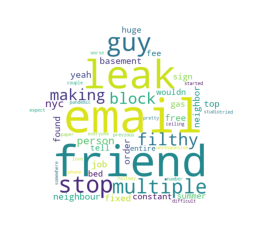

rating is 2


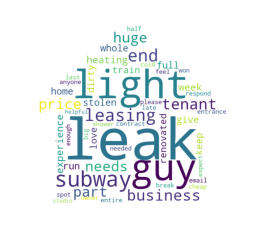

rating is 3


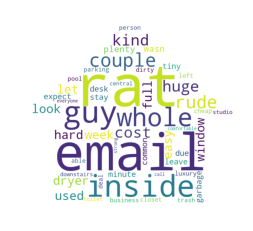

rating is 4


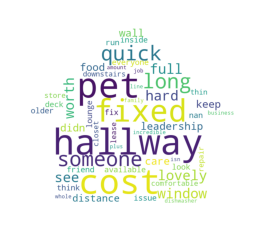

rating is 5


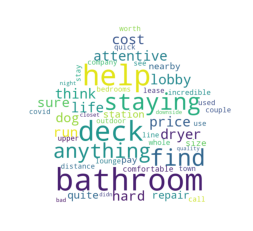

In [98]:
MAX_words = 50
wordcloud_l = []
for i in range(len(reviews_freq)):
    s = reviews_freq.iloc[i]
    print(f'rating is {i+1}')
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',width=3000,height=3000, mask = mask, max_words = MAX_words).generate(s)
    wordcloud_l.append(wordcloud)
#     wordcloud.max_words = 10
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

get the most important words and corresponding importances in each wordcloud

In [99]:
N = 20
wordcloud_df = pd.DataFrame(data = None,
                           index = range(5),
                           columns= ['Rating'] + list(range(N)))
for i in range(len(wordcloud_df)):
    wordcloud_df['Rating'].iloc[i] = i+1
#     wordcloud_df.iloc[i,:] = sorted(wordcloud_l[i].words_.items(), key = lambda x: x[1], reverse = True)[:20]
    temp = sorted(wordcloud_l[i].words_.items(), key = lambda x: x[1], reverse = True)[:20]
    for j in range(N):
        wordcloud_df[j].iloc[i] = temp[j]

In [102]:
wordcloud_df.transpose()

,0,1,2,3,4
Rating,1,2,3,4,5
0,"(email, 1.0)","(leak, 1.0)","(rat, 1.0)","(hallway, 1.0)","(bathroom, 1.0)"
1,"(friend, 0.9310344827586207)","(light, 0.723404255319149)","(email, 0.9761904761904762)","(pet, 0.9622641509433962)","(help, 0.8727272727272727)"
2,"(leak, 0.7758620689655172)","(guy, 0.6382978723404256)","(guy, 0.9523809523809523)","(cost, 0.9245283018867925)","(deck, 0.8)"
3,"(guy, 0.7413793103448276)","(subway, 0.6382978723404256)","(inside, 0.9285714285714286)","(fixed, 0.9056603773584906)","(staying, 0.7818181818181819)"
4,"(stop, 0.6551724137931034)","(leasing, 0.5957446808510638)","(whole, 0.9285714285714286)","(someone, 0.9056603773584906)","(find, 0.7818181818181819)"
5,"(multiple, 0.6379310344827587)","(end, 0.5957446808510638)","(couple, 0.9285714285714286)","(long, 0.9056603773584906)","(anything, 0.7818181818181819)"
6,"(filthy, 0.6379310344827587)","(business, 0.5957446808510638)","(rude, 0.9285714285714286)","(quick, 0.9056603773584906)","(attentive, 0.7818181818181819)"
7,"(making, 0.6379310344827587)","(tenant, 0.5957446808510638)","(huge, 0.9285714285714286)","(lovely, 0.9056603773584906)","(price, 0.7818181818181819)"
8,"(block, 0.6379310344827587)","(price, 0.5957446808510638)","(cost, 0.9047619047619048)","(see, 0.8867924528301887)","(lobby, 0.7636363636363637)"


### Recommendation 

**Rules**

1. radius <= 5KM
2. RentCity score reverse with highest review numbers
3. price [pending]
4. surroundings [pending]

return top 25 potential buildings

In [56]:
# example
# input is google place id
cur_sel = df_geo.iloc[14]['Google Places ID']
# cur_df = df_full[df_full['Google Places ID'] == cur_sel].iloc[0]
# cur_df

In [59]:
df_geo = get_geo_df() # recommend run in globally to save time
def recom(cur_sel, DIST_const = 5000, MAX_ret = 25):
#     df_full = get_df()
    cur_df = df_geo[df_geo['Google Places ID'] == cur_sel].iloc[0]
    potential_building_df = pd.DataFrame(data = None, columns=df_geo.columns.to_list() + ['distance'])
    for i in range(len(df_geo)):
        temp = df_geo.iloc[i]
        if cur_sel == temp['Google Places ID']:
            continue
        else:
            cur_loc = cur_df[['x','y','z']].to_numpy()
            temp_loc = temp[['x','y','z']].to_numpy()
            dist = get_arc(cur_loc, temp_loc)
            if dist <= DIST_const:
    #             print(i, ' ', dist)
                potential_building_df = potential_building_df.append(temp)
                potential_building_df['distance'].iloc[-1] = dist
        if len(potential_building_df) >= MAX_ret:
            break
    return potential_building_df.reset_index().drop(columns=['index'])

In [60]:
recom(cur_sel)

C:\Users\yuyang.he\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Google Places ID,Street Address,Neighborhood Mapping,City,Zip Code,RentCity Score,Neighborhood Safety Score,Building Code Violations,Walk Score,Count of Reviews,...,latitude,longitude,google_place_id,address,lat_arc,lon_arc,x,y,z,distance
0,ChIJ26GdM6ZZwokRo2ssZwWUQc0,10 East 29th Street,Midtown,New York,10016,5.0,3.7,A,0.99,13,...,40.744784,-73.986174,ChIJ26GdM6ZZwokRo2ssZwWUQc0,"10 E 29th St, New York, NY 10016",0.711131,-1.291302,0.209005,-0.728225,0.652691,1010.674754
1,ChIJPUAbf1pYwokRqoE22_m7Rfs,515 West 52nd Street,Midtown,New York,10019,5.0,4.7,A,0.97,12,...,40.766513,-73.991627,ChIJPUAbf1pYwokRqoE22_m7Rfs,"515 W 52nd St, New York, NY 10019",0.711510,-1.291398,0.208868,-0.728007,0.652978,2956.883122
2,ChIJ0eG6e6NZwokRqyzV9lusqUI,37 West 21st Street,Midtown West,New York,10010,5.0,4.0,A,1.00,11,...,40.741182,-73.992317,ChIJ0eG6e6NZwokRqyzV9lusqUI,"37 W 21st St, New York, NY 10010",0.711068,-1.291410,0.208939,-0.728287,0.652643,1537.208976
3,ChIJxW3GWAJZwokR_v7zht7c56s,150 East 44th Street,Midtown,New York,10017,5.0,4.8,A,1.00,11,...,40.752171,-73.974171,ChIJxW3GWAJZwokR_v7zht7c56s,"150 E 44th St, New York, NY 10017",0.711260,-1.291093,0.209135,-0.728100,0.652788,975.493961
4,ChIJpe6W6a9YwokR4Lmvnu4ADFg,408 East 92nd Street,Upper East Side,New York,10128,5.0,4.7,A,0.99,11,...,40.780369,-73.946305,ChIJpe6W6a9YwokR4Lmvnu4ADFg,"408 E 92nd St, New York, NY 10128",0.711752,-1.290606,0.209400,-0.727690,0.653161,4744.667177
5,ChIJV6onNUxYwokR7pV7mjyhoKU,560 West 43rd Street,Midtown,New York,10036,5.0,5.7,A,0.97,11,...,40.761169,-73.997746,ChIJV6onNUxYwokR7pV7mjyhoKU,"560 W 43rd St, New York, NY 10036",0.711417,-1.291504,0.208807,-0.728088,0.652907,2794.326559
6,ChIJVZrRZ6hZwokR4w0R1F9Xx2E,309 5th Avenue,Midtown,New York,10016.0,5.0,3.7,A,1.00,11,...,40.746710,-73.985318,ChIJVZrRZ6hZwokR4w0R1F9Xx2E,"THE DYLAN, 309 5th Ave, New York, NY 10016",0.711164,-1.291287,0.209010,-0.728201,0.652716,997.014386
7,ChIJ-YZS1LpZwokRVIEHar3SfkU,160 West 24th Street,Midtown West,New York,10011.0,5.0,4.6,A,0.98,11,...,40.744575,-73.994927,ChIJ-YZS1LpZwokRVIEHar3SfkU,"160 W 24th St, New York, NY 10011",0.711127,-1.291455,0.208895,-0.728259,0.652688,1742.110763
8,ChIJsUk8NBZawokRiz33YV5stwY,70 Pine Street Pine Street,Downtown Manhattan,New York,10005.0,5.0,3.1,A,1.00,11,...,40.706505,-74.007771,ChIJsUk8NBZawokRiz33YV5stwY,"70 Pine Street, 70 Pine St, New York, NY 10270",0.710463,-1.291679,0.208851,-0.728723,0.652184,4983.624714
9,ChIJQeBtpR1awokRxaye6Yd5I4E,41 River Terrace,Battery Park City,New York,10282,5.0,9.4,A,0.98,10,...,40.718246,-74.014582,ChIJQeBtpR1awokRxaye6Yd5I4E,"41 River Terrace, New York, NY 10282",0.710667,-1.291798,0.208727,-0.728619,0.652340,4401.817594
